# Importing:

In [1]:
# munging imports
import pandas as pd 
import numpy as np

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# Collecting and Exploring:

In [2]:
df=pd.read_csv("cardio_train.csv", sep=';')
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
cardio = df[df.cardio==1]
cardio.shape

(34979, 13)

In [5]:
cardio = df[df.cardio==0]
cardio.shape

(35021, 13)

In [6]:
# to check the data balance
df['cardio'].sum()/len(df) *100

49.97

In [7]:
df.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


#### Data features:

ID: id number, int

Age: Objective Feature,int, age in days

Gender: Objective Feature, int, gender in categorical code "Female=1 , Male=2"

Height: Objective Feature,int, height in cm

Weight: Objective Feature,float, weightin in kg

Systolic blood pressure: Examination Feature, int, ap_hi

Diastolic blood pressure: Examination Feature, int, ap_lo

Cholesterol: Examination Feature, int, cholesterol "normal=1 , above normal=2, well above normal=3"

Glucose: Examination Feature,int, gluc "normal=1, above normal=2, well above normal=3"

Smoking: Subjective Feature, int, smoke in binary "smoke=1, not smoke=0"

Alcohol intake: Subjective Feature,int, alco in binary "drink=1, not drink=0"

Physical activity: Subjective Feature, int, active in binary "active=1 , not active=0"

Presence or absence of cardiovascular disease: Target Variable, int, cardio in binary "cardiovascular disease=1, no cardiovascular disease=0"

In [8]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


#####  we can see that ap_hi has a min of  -150.000000 and ap_lo has min of -70.000000 which is wrong, there is no negative value of blood pressure. we can deticte that there is missing value.

##### also, min of weight is equal to 10km and min height is equal to 55cm for an adul. which in this case consedered as outliers and we can deal with it as replacing them with the mean of each of them depending on gender.

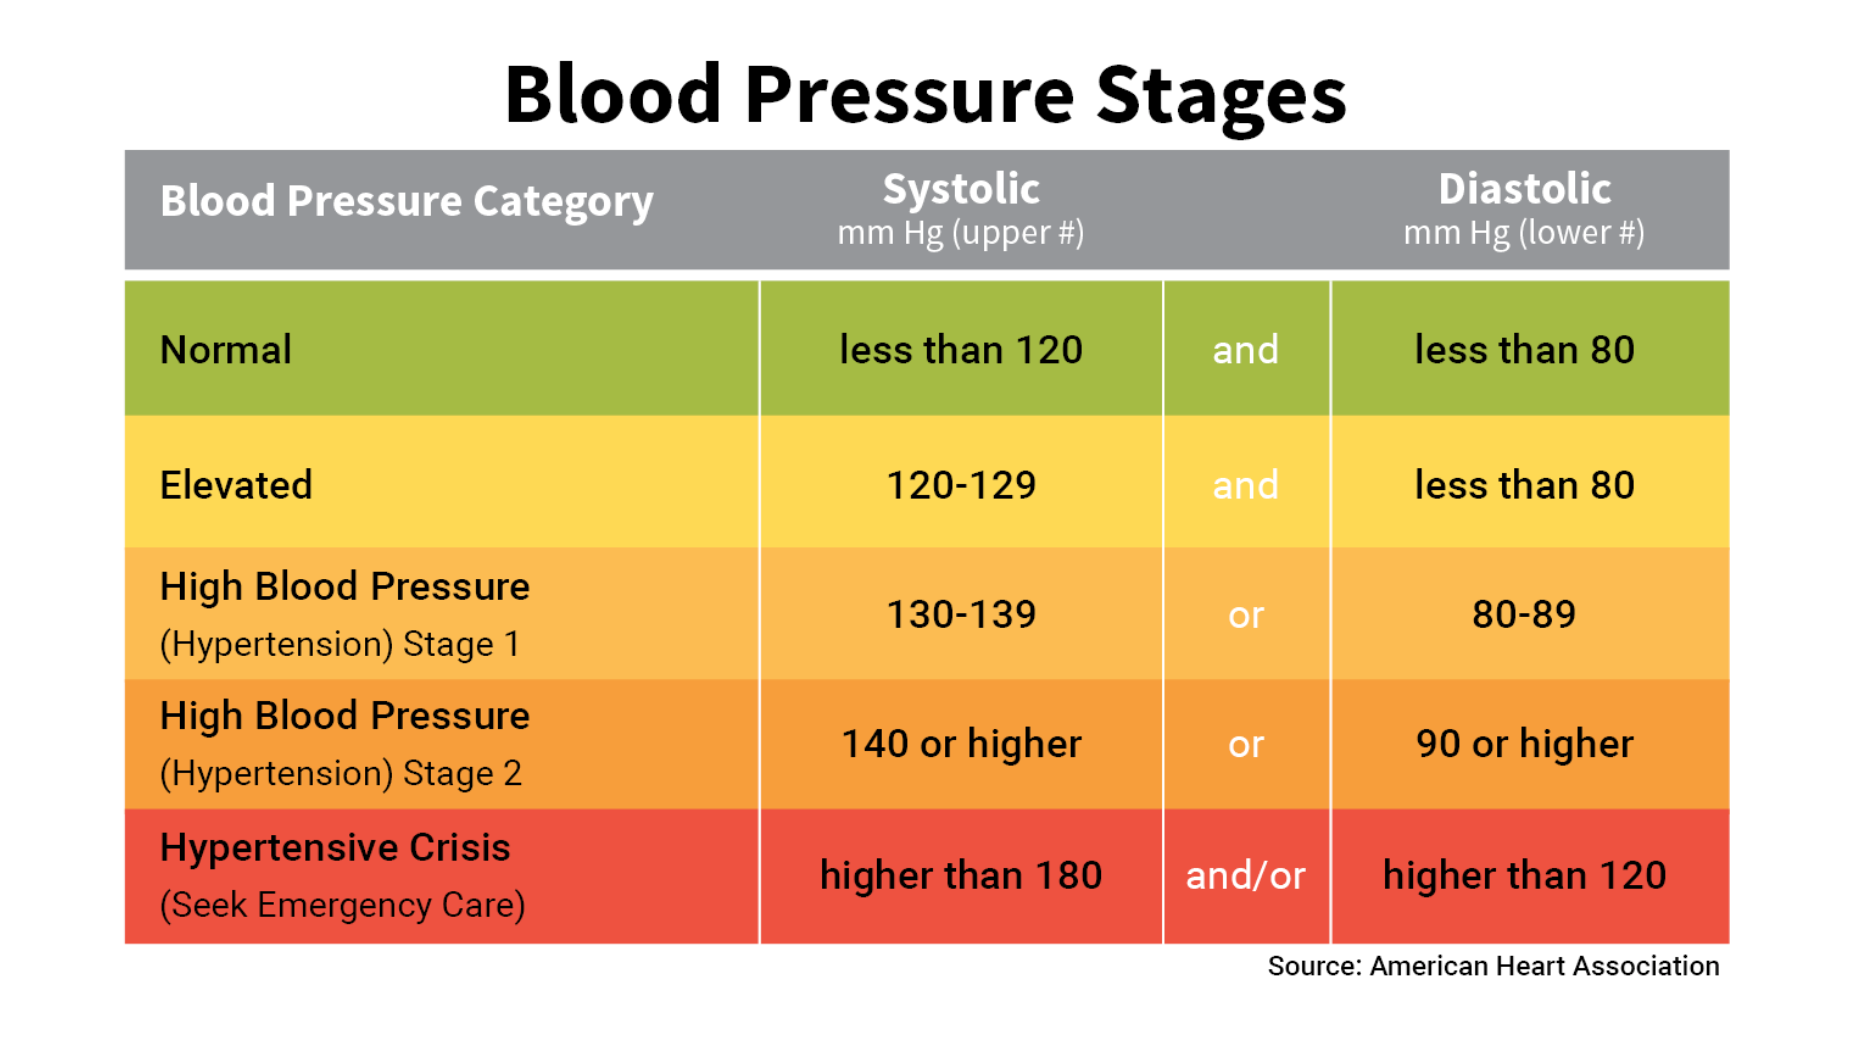

In [9]:
df.drop(df.query('ap_hi >220 or ap_lo >180 or ap_hi<40 or ap_lo<40').index, axis=0, inplace=True)

In [10]:
def bpstages(x,y):
    if x<=120 and y<=80:
        return 'normal'
    elif x<=129 and y<=80:
        return 'elevated'
    elif x<=139 or y<=89:
        return 'high stage 1'
    elif x<=180 or y<=120:
        return "high stage 2"
    elif x>180 or y>120:
        return 'hypertensive crisis'
    else:
        return None
    
df.insert(8, "BPC", df.apply(lambda row: bpstages(row['ap_hi'], row['ap_lo']), axis=1))
df['BPC'].value_counts()

#bpstages means blood pressure stages, and I categorized it according to the systolic and diastolic pressure.
#BPC means blood pressure categories, and I labled it based on the patients blood pressure like normal, elevated, high stage 1, high stage 2 or hypertensive crisis.

normal                 38895
high stage 1           15211
high stage 2           14211
elevated                 419
hypertensive crisis       28
Name: BPC, dtype: int64

In [11]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,BPC,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,normal,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,high stage 2,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,high stage 1,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,high stage 2,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,normal,1,0,0,0,0


In [12]:
BPCD=pd.get_dummies(df.BPC)
df=pd.concat([df,BPCD], axis=1)

In [13]:
df.drop('BPC',axis='columns',inplace=True)

In [14]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,0,0,0,0,1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,0,0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0,1,0,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,0,0,1,0,0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,0,0,0,0,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68764 entries, 0 to 69999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   68764 non-null  int64  
 1   age                  68764 non-null  int64  
 2   gender               68764 non-null  int64  
 3   height               68764 non-null  int64  
 4   weight               68764 non-null  float64
 5   ap_hi                68764 non-null  int64  
 6   ap_lo                68764 non-null  int64  
 7   cholesterol          68764 non-null  int64  
 8   gluc                 68764 non-null  int64  
 9   smoke                68764 non-null  int64  
 10  alco                 68764 non-null  int64  
 11  active               68764 non-null  int64  
 12  cardio               68764 non-null  int64  
 13  elevated             68764 non-null  uint8  
 14  high stage 1         68764 non-null  uint8  
 15  high stage 2         68764 non-null 

In [16]:
df = df[df['height'] >= 150]
df[df['height'] > 200]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal
6486,9223,21220,1,250,86.0,140,100,3,1,0,0,1,1,0,0,1,0,0
21628,30894,19054,2,207,78.0,100,70,1,1,0,1,1,0,0,0,0,0,1


In [17]:
df = df[df['weight'] >= 50]
df[df['weight'] > 190]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal
435,618,16765,1,186,200.0,130,70,1,1,0,0,0,0,0,1,0,0,0
50413,71945,15117,2,180,200.0,150,90,1,1,0,0,1,1,0,0,1,0,0


In [18]:
df.drop(index=6486, inplace= True)

In [19]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal
count,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000,66465.000000
mean,49900.863943,19455.305243,1.358158,164.915565,74.655809,126.705680,81.445392,1.363650,1.226555,0.089867,0.054540,0.802723,0.496698,0.006124,0.221335,0.207132,0.000421,0.564989
std,28834.131770,2464.135915,0.479463,7.420975,13.946706,16.601246,9.578097,0.678645,0.572770,0.285993,0.227082,0.397946,0.499993,0.078014,0.415148,0.405254,0.020521,0.495762
min,0.000000,10798.000000,1.000000,150.000000,50.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24948.000000,17652.000000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49884.000000,19695.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,74758.000000,21312.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,99999.000000,23713.000000,2.000000,207.000000,200.000000,220.000000,180.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df.drop('id',axis='columns',inplace=True) #id is unnecessary featuer

In [21]:
df['ageinyears'] = df['age'] / 365        #to change age from days to years
df= df.drop('age', axis=1)


In [22]:
df.rename({"ageinyears":"age"},axis=1, inplace=True)

In [23]:
df.sample(5)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal,age
4503,2,175,111.0,160,100,1,2,0,0,1,1,0,0,1,0,0,55.435616
38054,1,164,59.0,120,80,1,1,0,0,1,0,0,0,0,0,1,40.586301
60189,1,164,78.0,120,80,1,1,0,0,0,0,0,0,0,0,1,53.978082
17089,2,155,69.0,120,80,1,1,0,0,1,1,0,0,0,0,1,47.668493
31999,1,155,55.0,120,80,1,1,0,0,1,0,0,0,0,0,1,46.197260


In [24]:
df.isna()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal,age
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
69996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
69997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
69998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [25]:
df.dtypes

gender                   int64
height                   int64
weight                 float64
ap_hi                    int64
ap_lo                    int64
cholesterol              int64
gluc                     int64
smoke                    int64
alco                     int64
active                   int64
cardio                   int64
elevated                 uint8
high stage 1             uint8
high stage 2             uint8
hypertensive crisis      uint8
normal                   uint8
age                    float64
dtype: object

In [26]:
# Gender: Female= 0  and Male=1
df['gender']=df['gender']-1

In [27]:
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal,age
0,1,168,62.0,110,80,1,1,0,0,1,0,0,0,0,0,1,50.391781
1,0,156,85.0,140,90,3,1,0,0,1,1,0,0,1,0,0,55.419178
2,0,165,64.0,130,70,3,1,0,0,0,1,0,1,0,0,0,51.663014
3,1,169,82.0,150,100,1,1,0,0,1,1,0,0,1,0,0,48.282192
4,0,156,56.0,100,60,1,1,0,0,0,0,0,0,0,0,1,47.873973


In [28]:
df.describe().T[0:]

,count,mean,std,min,25%,50%,75%,max
gender,66465.0,0.358158,0.479463,0.000000,0.000000,0.000000,1.000000,1.000000
height,66465.0,164.915565,7.420975,150.000000,160.000000,165.000000,170.000000,207.000000
weight,66465.0,74.655809,13.946706,50.000000,65.000000,72.000000,82.000000,200.000000
ap_hi,66465.0,126.705680,16.601246,60.000000,120.000000,120.000000,140.000000,220.000000
ap_lo,66465.0,81.445392,9.578097,40.000000,80.000000,80.000000,90.000000,180.000000
cholesterol,66465.0,1.363650,0.678645,1.000000,1.000000,1.000000,1.000000,3.000000
gluc,66465.0,1.226555,0.572770,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,66465.0,0.089867,0.285993,0.000000,0.000000,0.000000,0.000000,1.000000
alco,66465.0,0.054540,0.227082,0.000000,0.000000,0.000000,0.000000,1.000000
active,66465.0,0.802723,0.397946,0.000000,1.000000,1.000000,1.000000,1.000000


In here we can conclude that:

The percentage of males is 35% while the percentage of females is 65%.

The mean height of patients is 164.91 cm.

The mean weight of patients is 74.65 Kg.

The percentage of smokers is 8%.

The percentage of alcoholists is 5%.

The percentage of Active patients is 80%.

The mean age for patient is 53 years.

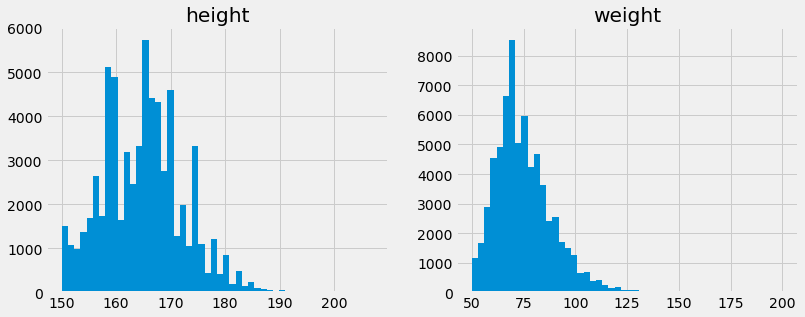

In [29]:
#to check if still we have outliers in height and weight
plt.figure(figsize=(12,10))

he= plt.subplot(221)
he= plt.hist(df['height'], bins=50)
he= plt.title('height')

we= plt.subplot(222)
we= plt.hist(df['weight'], bins=50)
we= plt.title('weight')


In [30]:
df.sample(6)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,elevated,high stage 1,high stage 2,hypertensive crisis,normal,age
55718,0,169,70.0,130,70,1,1,1,0,0,1,0,1,0,0,0,59.753425
57128,0,169,58.0,120,80,1,1,0,0,1,0,0,0,0,0,1,60.600000
39644,0,156,60.0,130,80,2,1,0,0,0,1,0,1,0,0,0,56.336986
56546,1,173,72.0,110,70,1,1,0,0,1,0,0,0,0,0,1,47.547945
6603,1,191,123.0,150,100,1,1,1,0,0,1,0,0,1,0,0,51.701370
6425,0,163,99.0,120,80,2,2,0,0,1,0,0,0,0,0,1,45.753425


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66465 entries, 0 to 69999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               66465 non-null  int64  
 1   height               66465 non-null  int64  
 2   weight               66465 non-null  float64
 3   ap_hi                66465 non-null  int64  
 4   ap_lo                66465 non-null  int64  
 5   cholesterol          66465 non-null  int64  
 6   gluc                 66465 non-null  int64  
 7   smoke                66465 non-null  int64  
 8   alco                 66465 non-null  int64  
 9   active               66465 non-null  int64  
 10  cardio               66465 non-null  int64  
 11  elevated             66465 non-null  uint8  
 12  high stage 1         66465 non-null  uint8  
 13  high stage 2         66465 non-null  uint8  
 14  hypertensive crisis  66465 non-null  uint8  
 15  normal               66465 non-null 

In [32]:
df.duplicated().sum()   # to check if i have duplicate

24

In [33]:
df.drop_duplicates(inplace=True)   # to remove the duplicate rows

In [34]:
df.groupby('cardio').mean()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,elevated,high stage 1,high stage 2,hypertensive crisis,normal,age
cardio,,,,,,,,,,,,,,,,
0,0.355256,165.020846,72.220504,119.726215,78.279109,1.215253,1.176402,0.094572,0.056528,0.817287,0.007866,0.159444,0.064483,0.000090,0.768117,51.714927
1,0.361268,164.809156,77.129092,133.781040,84.654184,1.514240,1.277525,0.085166,0.052566,0.787948,0.004363,0.284191,0.351785,0.000757,0.358904,54.910578


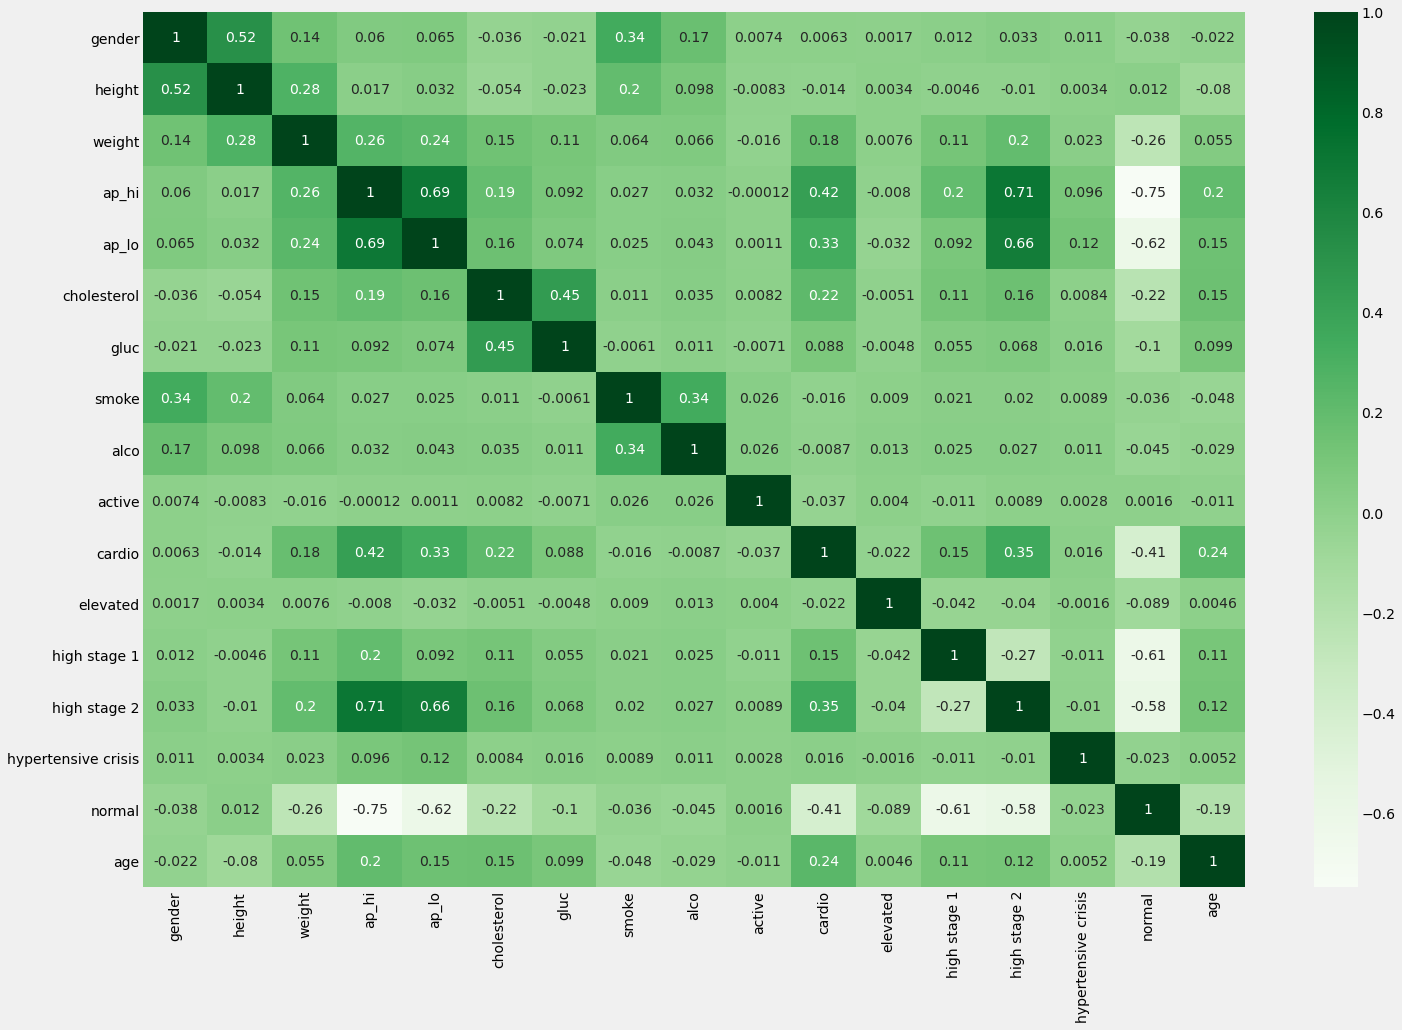

In [44]:
plt.figure(figsize=(22,15))
sns.heatmap(df.corr(),annot=True ,cmap='Greens')
plt.show()

Looking into the correlation heatmap, and it seems like our target has either positive or negative higher correlation with weight,ap_hi,ap_lo, cholesterol, high stage 1, high stage 2, normal, age.


In [ ]:
pd.crosstab(df['cardio'], df['gender']).plot(kind = 'bar')
plt.xlabel('no heart disease             heart disease')
plt.legend(['female','male'],loc='upper right')
plt.show()

##### according to the plot, we can see that male in both cases of having or not having a heart disease is almost the same value while female who has a heart disease is slightly lower than females who have it. also by comparing between of gender the mejority of heart disease patients are females with more than 20,000 patients.

In [ ]:
X=df[['age','height','gender','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','high stage 1','high stage 2','normal','hypertensive crisis','elevated']]
y=df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=43)

In [ ]:
train_df = X_train.copy()
train_df['cardio'] = y_train
train_df.head()

In [ ]:
sns.pairplot(train_df, hue='cardio');

In [ ]:
sns.boxplot(x='cardio', y='age', data=train_df);

In [ ]:
# Logistic Regression

lr = LogisticRegression()
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

fit=lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr.intercept_
lr.coef_

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
lr.score(X_test,y_test)

In [ ]:
# Decision Tree

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test,y_test)

In [ ]:
# KNN

knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)
knn.score(X_test,y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [ ]:
# Gradient Boosting Machines

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', 
                    early_stopping_rounds=50,
                    verbose=True
                   )



In [ ]:
accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

In [ ]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

Gain views that normal blood pressure is the most important featuer while in frequency it is not.

In [ ]:
# Random Forest
rf= RandomForestClassifier(criterion = "entropy")
rf.fit(X_train, y_train)
rf.score(X_test,y_test)

In [ ]:
X = df.drop(["active"], axis = 1).values
y = df["active"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

In [ ]:
# Naive Bayes

nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

In [ ]:
# Dummy 

X=df[['age','height','gender','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','high stage 1','high stage 2','normal','hypertensive crisis','elevated']]
y=df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=43)
dummys= DummyClassifier(strategy="most_frequent")
dummys.fit(X_train, y_train)
dummys.score(X_test,y_test)